In [1]:
import sys
import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np
from scipy import stats, integrate
import matplotlib.ticker as tk
import matplotlib as mpl
import os
import re

sys.path.append('/appch/data/jtb34/GitHub/GACF/')
from NGTS.NGTS_Field import return_field_from_object_directory
from NGTS.NGTS_Object import return_object_from_json_string
from NGTS.GACF_utils import TIME_CONVERSIONS#, fourier_transform_and_peaks

from astropy.io import fits

In [2]:
ROOT_DIR = '/appch/data/jtb34'
# ROOT_DIR = '/appch/data/jtb34/GitHub/GACF/example/Blanco1'
CYCLE = 'CYCLE1807'

In [3]:
def get_json_string(fieldname, obj_id):
    object_file_name = '{0}_VERSION_{1}'.format(obj_id, CYCLE)
    object_file = os.path.join(*[ROOT_DIR, fieldname, object_file_name, 'object.json'])
    with open(object_file, 'r') as f:
        jsonstr = f.read() 
    return jsonstr

def get_gaia_params(obj):

    XMATCH_LOCATION = '/appch/data/jtb34/{}/cross_match/'.format(obj.field)
    FILE_NAME = 'Uncut_Final_{}.fits'.format(obj.field)
    xmatch_data = fits.open(os.path.join(XMATCH_LOCATION, FILE_NAME))

    for i, obj_id in enumerate(xmatch_data[1].data['Sequence_number']):
        if int(obj.obj) == int(obj_id):
            obj.Gaia_Teff = xmatch_data[1].data['Gaia_Teff'][i]
            obj.Gaia_Radius = xmatch_data[1].data['Gaia_Radius'][i]
            obj.Gaia_Lum = xmatch_data[1].data['Gaia_Lum'][i]
            obj.TWOMASS_Hmag = xmatch_data[1].data['2MASS_Hmag'][i]
            obj.TWOMASS_Kmag = xmatch_data[1].data['2MASS_Kmag'][i]
            obj.APASS_Vmag = xmatch_data[1].data['APASS_Vmag'][i]
            obj.APASS_Bmag = xmatch_data[1].data['APASS_Bmag'][i]
            obj.Gaia_Gmag = xmatch_data[1].data['Gaia_Gmag'][i]
            obj.BminusV = obj.APASS_Bmag - obj.APASS_Vmag
            obj.HminusK = obj.TWOMASS_Hmag - obj.TWOMASS_Kmag
            obj.GminusK = obj.Gaia_Gmag - obj.TWOMASS_Kmag
    return obj
    
def create_obj(fieldname, obj_id):
    obj = return_object_from_json_string(get_json_string(fieldname, obj_id))
    return get_gaia_params(obj)

In [4]:
# FIELDNAME = 'NG0004-2950'
# FIELDNAME = 'NG0535-0523'
# FIELDNAME = 'NG0504-3633'
FIELDNAME = 'NG2346-3633'
# FIELDNAME = 'NG2058-0248'

In [5]:
obj = create_obj(FIELDNAME, 54)
# obj = create_obj(FIELDNAME, 17623)
print obj

NGTS Object NG2346-3633_54 (CYCLE1807)


In [6]:
# Show resolution of (a) binned timeseries (b) G-ACF (c) Fourier Transform at various resolutions

binned_time_diffs = np.diff(obj.timeseries_binned) * TIME_CONVERSIONS['d2m']
print 'Time Resolutions: {} min, {} max, {} median (minutes)'.format(np.min(binned_time_diffs), 
                                                                     np.max(binned_time_diffs), 
                                                                     np.median(binned_time_diffs))
print 'Object Tbin', obj.tbin, "minutes"


Time Resolutions: 15.0714628295 min, 24062.771108 max, 29.9931654671 median (minutes)
Object Tbin 30 minutes


In [7]:
lag_time_diffs = np.diff(obj.lag_timeseries) * TIME_CONVERSIONS['d2m']
print 'Lag Resolutions: {} min, {} max, {} median (minutes)'.format(np.min(lag_time_diffs), 
                                                                    np.max(lag_time_diffs), 
                                                                    np.median(lag_time_diffs))
print 'Object lag resolution', obj.lag_resolution * TIME_CONVERSIONS['d2m'], "minutes"

Lag Resolutions: 30.0 min, 30.0 max, 30.0 median (minutes)
Object lag resolution 30.0 minutes


In [8]:
def calculate_period_resolution(cp, freq_res):
    cfreq = 1.0 / cp
    pfreq = cfreq + freq_res
    mfreq = cfreq - freq_res
    pp = 1.0 / pfreq
    mp = 1.0 / mfreq
    return np.max([abs(pp - cp), abs(mp - cp)])
    

freqs = np.divide(1.0, obj.period_axis)
freq_resolution = np.median(np.diff(freqs))
resolution_periods = [1,10, 20, 30, 50]
for p in resolution_periods:
    print 'Fourier Transform resolution at {} days: {} minutes'.format(p, calculate_period_resolution(p, freq_resolution) * TIME_CONVERSIONS['d2m'])

Fourier Transform resolution at 1 days: 0.0164796807826 minutes
Fourier Transform resolution at 10 days: 1.64813783316 minutes
Fourier Transform resolution at 20 days: 6.59330596297 minutes
Fourier Transform resolution at 30 days: 14.8366367237 minutes
Fourier Transform resolution at 50 days: 41.2223180684 minutes


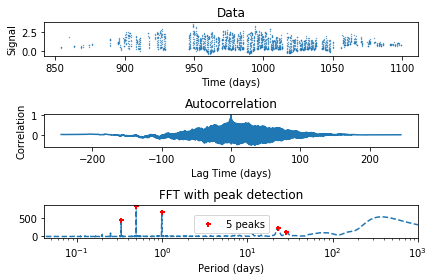

In [9]:
obj.plot_data_autocol_ft(interactive=True)

In [ ]:
from numpy import fft
import peakutils
import time
def fourier_transform_and_peaks(correlations, lag_timeseries, len_ft=None, n=16, power_of_2=True, pad_both_sides=True):
    if len_ft is None:
        len_ft = len(lag_timeseries) * n

    if power_of_2:
        # add more zeros to make the length of the array a power of 2, for computational speed up
        len_ft = int(2.0 ** np.ceil(np.log2(len_ft)))

    # print 'number of samples', len_ft, '2 ** ', np.log2(len_ft)
    
    if pad_both_sides:
        num_zeros = len_ft - len(lag_timeseries)
        zeros = np.zeros(num_zeros / 2)
        correlations = np.append(zeros, np.append(correlations, zeros))

    complex_ft = fft.rfft(correlations, n=len_ft)
    freqs = fft.rfftfreq(len_ft, lag_timeseries[1] - lag_timeseries[0])

    periods = 1 / freqs
    ft = np.abs(complex_ft)

    # Find peaks of FFT

    indexes = peakutils.indexes(ft, thres=0.1,  # Fraction of largest peak
                                min_dist=3  # Number of data points between
                                )

    return ft, periods, indexes

In [ ]:
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})

fig, ax = plt.subplots(figsize=(10,7))
ax.plot(obj.lag_timeseries, obj.correlations, lw=1)
ax.set_xlim([-10,10])
plt.show()

# ft, periods, indexes = fourier_transform_and_peaks(obj.correlations, obj.lag_timeseries, pad_both_sides=False)
# fig, ax = plt.subplots(figsize=(10,7))
# ax.plot(periods, ft, lw=0.1)
# ax.scatter(periods, ft, s=1)
# ax.scatter(periods[indexes], ft[indexes], s=80, marker='+', c='r')
# ax.axvline(x=max(obj.lag_timeseries), lw=1, c='b')
# ax.axvline(x=max(obj.lag_timeseries)/2, lw=1, c='r')
# # ax.set_xlim([-10,10])
# # ax.set_xlim(right=max(obj.lag_timeseries))
# ax.set_xscale('log')
# ax.set_title('Without padding both sides')
# plt.show()

# print 'Periods', periods[indexes]

ft, periods, indexes = fourier_transform_and_peaks(obj.correlations, obj.lag_timeseries, pad_both_sides=True)
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(periods, ft, lw=0.1)
ax.scatter(periods, ft, s=1)
ax.scatter(periods[indexes], ft[indexes], s=80, marker='+', c='r')
ax.axvline(x=max(obj.lag_timeseries), lw=1, c='b')
ax.axvline(x=max(obj.lag_timeseries)/2, lw=1, c='r')
ax.set_xlim([10,40])
# ax.set_xscale('log')
ax.set_title('With padding both sides')
plt.show()

print 'Periods', periods[indexes]

summ = []
summ2 = []
# times = []

ns = [1, 2, 4, 8, 16, 32, 64, 128]

for i in ns:
    t1 = time.time()
    ft, periods, indexes = fourier_transform_and_peaks(obj.correlations, obj.lag_timeseries, pad_both_sides=True, n=i)
    t2 = time.time()
    
    freqs = np.divide(1.0, periods[::-1])
    freq_resolution = np.median(np.diff(freqs))
    p = 20.0
    print 'n={}, Fourier Transform resolution at {} days: {} minutes'.format(i,
        p, calculate_period_resolution(p, freq_resolution) * TIME_CONVERSIONS['d2m'])
#     fig, ax = plt.subplots(figsize=(10,7))
#     ax.plot(periods, ft, lw=0.1)
#     ax.scatter(periods, ft, s=1)
#     ax.scatter(periods[indexes], ft[indexes], s=80, marker='+', c='r')
#     # ax.set_xlim([-10,10])
#     ax.set_xscale('log')
#     ax.set_title('Padding factor' + str(i))
#     plt.show()
    
    summ.append(np.sum(periods[indexes]))
#     times.append(t2-t1)

#     print 'Periods', periods[indexes]
    
# print '*********************'
    
# for i in ns:
#     t1 = time.time()
#     ft, periods, indexes = fourier_transform_and_peaks(obj.correlations, obj.lag_timeseries, pad_both_sides=False, n=i)
#     t2 = time.time()
# #     fig, ax = plt.subplots(figsize=(10,7))
# #     ax.plot(periods, ft, lw=0.1)
# #     ax.scatter(periods, ft, s=1)
# #     ax.scatter(periods[indexes], ft[indexes], s=80, marker='+', c='r')
# #     # ax.set_xlim([-10,10])
# #     ax.set_xscale('log')
# #     ax.set_title('Padding factor' + str(i))
# #     plt.show()
    
#     summ2.append(np.sum(periods[indexes]))
# #     times.append(t2-t1)

#     print 'Periods', periods[indexes]
    
fig, ax = plt.subplots(figsize=(10,7))
# ax2 = ax.twinx()
ax.plot(ns, summ, label='Both sides padded')
ax.scatter(ns, summ)
# ax.plot(ns, summ2, c='r', label='End padded')
# ax.scatter(ns, summ2, c='r')
# ax2.plot(ns, times, c='r')
# ax2.scatter(ns, times, c='r')
# ax.set_xlim([-10,10])
ax.set_title('Convergance of periods')
ax.legend()
plt.show()

In [ ]:
periods[2900]- periods[2901]

In [ ]:
ft, pds, idx = fourier_transform_and_peaks(obj.correlations, obj.lag_timeseries)

In [ ]:
len(pds)

In [ ]:
plt.plot(obj.period_axis, obj.ft)
plt.xscale('log')
plt.xlim([0, 200])

In [ ]:
def calc_opposite_phase(phase):
    return abs(2 * np.pi - phase)
phase = -0.1*2*np.pi
print 'Outputted phase: ', phase
yeet = calc_opposite_phase(phase)
updated_phase = min(phase, yeet)
print 'New phase: ', updated_phase